# CartPole REINFORCE

In [68]:
import gymnasium as gym
import time
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Hyperparameters

In [69]:
LEARNING_RATE = 0.001
GAMMA = 0.99
HIDDEN_SIZE = 128
EPISODES = 2000
MAX_STEPS = 1000
SEED = 540

### Set up environment

In [70]:
env = gym.make('CartPole-v1')
env.reset(seed=SEED)
torch.manual_seed(SEED)

In [71]:
SAVED_LOG_PROBS = []
REWARDS = []
POLICY_LOSSES = []

### Policy Network

In [72]:
class Policy(nn.Module):
    def __init__(self, n_observations, n_actions, hidden_size):
        super(Policy, self).__init__()
        self.layer1 = nn.Linear(n_observations, hidden_size)
        self.dropout = nn.Dropout(p=0.6)
        self.layer2 = nn.Linear(hidden_size, n_actions)

    def forward(self, x):
        x = self.layer1(x)
        x = self.dropout(x)
        x = F.relu(x)
        return F.softmax(self.layer2(x), dim=1)
    
    def action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state)
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

### Initialize Policy

In [73]:
POLICY = Policy(env.observation_space.shape[0], env.action_space.n, HIDDEN_SIZE)
OPTIMIZER = optim.Adam(POLICY.parameters(), lr=LEARNING_RATE)
EPS = np.finfo(np.float32).eps.item()

### Compute discounted returns

In [74]:
def compute_returns(rewards, gamma):
    R = 0
    returns = deque()
    for r in reversed(rewards):
        R = r + gamma * R
        returns.appendleft(R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + EPS)
    return returns

### Compute Policy Loss

In [75]:
def compute_policy_loss(saved_log_probs, returns):
    policy_loss = [-log_prob * R for log_prob, R in zip(saved_log_probs, returns)]
    policy_loss = torch.cat(policy_loss).sum()
    return policy_loss

### Backpropagation

In [76]:
def backpropagate(policy_loss, optimizer):
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

### Update Policy after episode

In [77]:
def update():    
    returns = compute_returns(REWARDS, GAMMA)
    policy_loss = compute_policy_loss(SAVED_LOG_PROBS, returns)
    POLICY_LOSSES.append(policy_loss.item())
    backpropagate(policy_loss, OPTIMIZER)
    del REWARDS[:]
    del SAVED_LOG_PROBS[:]

### Train REINFORCE agent

In [78]:
episode_rewards = np.zeros(EPISODES)
average_reward = []
solved_episode = None

start = time.time()
for episode in range(EPISODES):
    state, _ = env.reset()
    cumulative_reward = 0.0
    for _ in range(MAX_STEPS):
        action, log_probs = POLICY.action(state)
        SAVED_LOG_PROBS.append(log_probs)
        state, reward, terminated, truncated, _ = env.step(action)
        REWARDS.append(reward)
        cumulative_reward += reward
        if terminated:
            break

    episode_rewards[episode] = cumulative_reward
    print(f"Episode: {episode}, Rewards: {cumulative_reward}")
    update()

    if episode >= 100:
        avg_reward = sum(episode_rewards[episode-100:episode]) / 100
        average_reward.append(avg_reward)
        if avg_reward >= 475 and solved_episode is None:
            solved_episode = episode
    else:
        average_reward.append(sum(episode_rewards[:episode]) / 100)

end = time.time()
training_time = end - start

Episode: 0, Rewards: 14.0
Episode: 1, Rewards: 10.0
Episode: 2, Rewards: 15.0
Episode: 3, Rewards: 15.0
Episode: 4, Rewards: 37.0
Episode: 5, Rewards: 26.0
Episode: 6, Rewards: 21.0
Episode: 7, Rewards: 15.0
Episode: 8, Rewards: 29.0
Episode: 9, Rewards: 15.0
Episode: 10, Rewards: 18.0
Episode: 11, Rewards: 22.0
Episode: 12, Rewards: 38.0
Episode: 13, Rewards: 11.0
Episode: 14, Rewards: 19.0
Episode: 15, Rewards: 16.0
Episode: 16, Rewards: 20.0
Episode: 17, Rewards: 16.0
Episode: 18, Rewards: 13.0
Episode: 19, Rewards: 27.0
Episode: 20, Rewards: 11.0
Episode: 21, Rewards: 11.0
Episode: 22, Rewards: 48.0
Episode: 23, Rewards: 17.0
Episode: 24, Rewards: 18.0
Episode: 25, Rewards: 12.0
Episode: 26, Rewards: 13.0
Episode: 27, Rewards: 13.0
Episode: 28, Rewards: 18.0
Episode: 29, Rewards: 15.0
Episode: 30, Rewards: 49.0
Episode: 31, Rewards: 23.0
Episode: 32, Rewards: 8.0
Episode: 33, Rewards: 27.0
Episode: 34, Rewards: 12.0
Episode: 35, Rewards: 21.0
Episode: 36, Rewards: 41.0
Episode: 37,

### Print Metrics

In [79]:
print(f"Average Reward: {np.mean(episode_rewards)}")
print(f"Average Reward (last 100): {np.mean(episode_rewards[-100:])}")
print(f"Solved at episode: {solved_episode}")
print(f"Training Time (seconds): {training_time}")

Average Reward: 632.362
Average Reward (last 100): 987.14
Solved at episode: 781
Training Time (seconds): 641.4740862846375


### Plot Results

/home/noname/anaconda3/envs/cartpole/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/noname/anaconda3/envs/cartpole/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/noname/anaconda3/envs/cartpole/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/noname/anaconda3/envs/cartpole/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

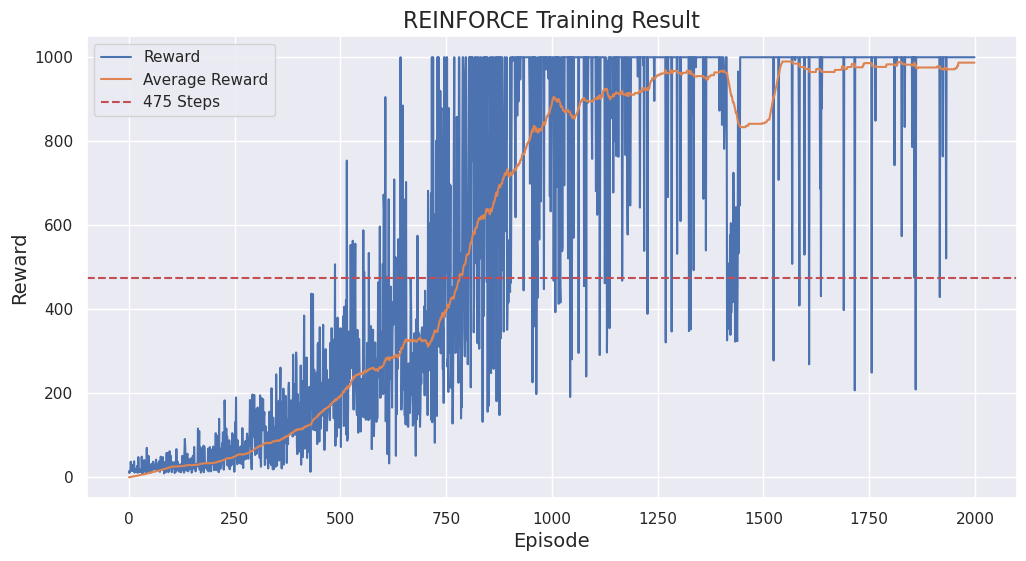

In [80]:
# Plotting the original reward and average reward
data = {
    'Episode': range(EPISODES),
    'Reward': episode_rewards,
    'Average Reward': average_reward
}

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Episode', y='Reward', label='Reward')
sns.lineplot(data=df, x='Episode', y='Average Reward', label='Average Reward')
plt.axhline(y=475, color='r', linestyle='--', label='475 Steps')
plt.title('REINFORCE Training Result', fontsize=16)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.legend(loc='upper left')
plt.show()

/home/noname/anaconda3/envs/cartpole/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/noname/anaconda3/envs/cartpole/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


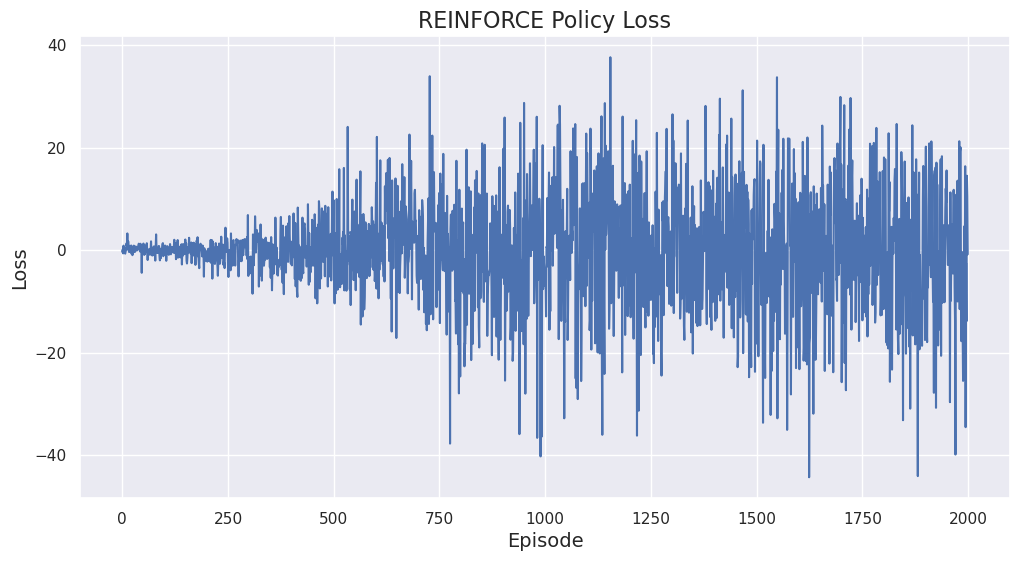

In [81]:
data = {
    'Episode': range(EPISODES),
    'Loss': POLICY_LOSSES,
}

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Episode', y='Loss')
plt.title('REINFORCE Policy Loss', fontsize=16)
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()